# Simulating Stock Prices with Monte Carlo Methods

## Abstract

Monte Carlo methods are a methodology by which we create a given model
of an event, generate a series of random values from that model, and 
apply those values as inputs to a scenario many times in order to simulate
what would happen over a long period of time. This allows us to make 
reasonable models of events whose probability distribution is inherently
non-deterministic or at least very difficult to model with analytical methods.


## Rationale

The four overarching steps to conducting a Monte Carlo analysis are:
    1. Construct a Model
    2. Generate Random Values
    3. Apply them over many, many trials
    4. Collect results and analyze.

### 1. Construct a Model

To model a stock price, we will simply assume that the change in price of
the stock will follow a normal distribution with a mean and standard
deviation (which, in finance, are called drift and shock respectively).

In [1]:
# Import required libraries

import math
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data

Now, we grab the financial data for Apple from Yahoo starting at January 1, 2000.

In [2]:
apple = data.DataReader('AAPL', 'yahoo',start='1/1/2000')

Next, we calculate the number of days that have elapsed for every price point.

In [3]:
time_elapsed = (apple.index[-1] - apple.index[0]).days


Then, we compute the compounded annual growth rate (cagr) by taking the ratio between the closing price and the opening price and rasing that value to the inverse of the number of years elapsed then substract 1 (in order to make it a percentage of growth).


In [4]:
price_ratio = (apple['Adj Close'][-1] / apple['Adj Close'][1])
inverse_number_of_years = 365.0 / time_elapsed
cagr = price_ratio ** inverse_number_of_years - 1

Now, let's determine the annual volatility of returns. Volatility is
the standard deviation of the percent changes in price for each day. This makes sense since it is a measure of how sporadically the price of the stock is changing.

In [5]:
vol = apple['Adj Close'].pct_change().std()

Now, in order to make this figure useful as an annual measure, it has to be scaled by an annualization factor. This factor is most often the square root of the number of trading days in a year which happens to be 252.

In [6]:
number_of_trading_days = 252
vol = vol * math.sqrt(number_of_trading_days)

Let's see what we get.

In [7]:
print ("cagr (mean returns) : ", str(round(cagr,4)))
print ("vol (standard deviation of return : )", str(round(vol,4)))

cagr (mean returns) :  0.261
vol (standard deviation of return : ) 0.4067


### 2. Generate Random Values

Perfect! This is all we need to model a standard deviation of stock prices. Now, let's actually create a random sample using these parameters. For this, we'll use the _normal_ function from the numpy library.

In [8]:
daily_return_percentages = np.random.normal(cagr/number_of_trading_days, vol/math.sqrt(number_of_trading_days),number_of_trading_days)+1

Alright. Now that we have a list of return percentages. Let's create a price series from this list. We'll start with the most recent price and go from there. Then, in order to generate each consecutive price, we will apply the price change to the most recent price. This will result in a distribution called a "random walk".

In [9]:
price_series = [apple['Adj Close'][-1]]

for drp in daily_return_percentages:
    price_series.append(price_series[-1] * drp)

Great! Now let's see what this "random walk" of stock prices looks like. 

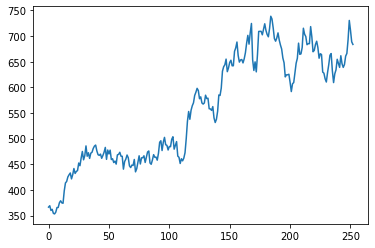

In [10]:
plt.plot(price_series)
plt.show()

Fantastic. We have shown a single simulation of a potential future price series that was based on the normal distribution of daily returns we calculated earlier. 

However, this by itself isn't particularly useful since this is just one out of the virtually infinite possible price series for this stock. The actual probability that the stock would follow this price series in the future is unfathomably close to zero. 

What's the use, you ask? Well, now, we can run this type of simulation many, many times, and that's when we gain the true insight.

### 3. Apply them over many, many trials

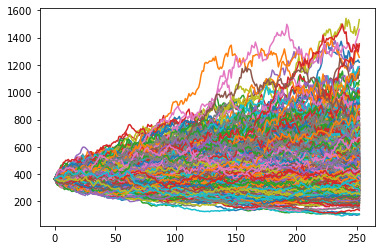

In [11]:
number_of_trials = 1000
for i in range(number_of_trials):
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, vol/math.sqrt(number_of_trading_days),number_of_trading_days)+1
    price_series = [apple['Adj Close'][-1]]

    for drp in daily_return_percentages:
        price_series.append(price_series[-1] * drp)
    
    plt.plot(price_series)
plt.show()

Cool! Here, we see what a thousand different possible price series look like. These are all randomly generated based on the intial conditions we set to describe the normal distribution of daily returns. 

While this chart is really pretty, it can be a bit cumbersome to meake meaninful interpretations from it. Instead, we shall construct a histogram of the ending price points. This way, we can see a distribution of where our "random" predictions "end up".

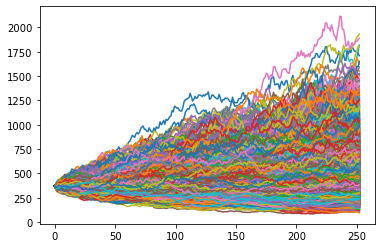

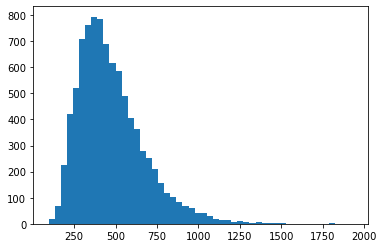

In [12]:
ending_price_points = []
larger_number_of_trials = 9001 # It's over 9000
for i in range(larger_number_of_trials):
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, vol/math.sqrt(number_of_trading_days),number_of_trading_days)+1
    price_series = [apple['Adj Close'][-1]]

    for drp in daily_return_percentages:
        price_series.append(price_series[-1] * drp)
    
    plt.plot(price_series)
    
    ending_price_points.append(price_series[-1])

plt.show()

plt.hist(ending_price_points,bins=50)
plt.show()

### 4. Collect Results and Analyze

Splendid! We're almost there. Now, let's get the mean of this distribution in order to get an expected value of our ending price points.

In [13]:
expected_ending_price_point = round(np.mean(ending_price_points),2)
print("Expected Ending Price Point : ", str(expected_ending_price_point))

Expected Ending Price Point :  475.02


Due to the Law of Large Numbers, this number (which you can think of as the sample mean) will eventually converge to the last, known price point multiplied by the expected daily price change (the population mean). 

In [14]:
population_mean = (cagr+1) * apple['Adj Close'][-1]
print ("Sample Mean : ", str(expected_ending_price_point))
print ("Population Mean: ", str(round(population_mean,2)));
print ("Percent Difference : ", str(round((population_mean - expected_ending_price_point)/population_mean * 100,2)), "%")

Sample Mean :  475.02
Population Mean:  462.2
Percent Difference :  -2.77 %


The true usefulness of Monte Carlo simulations, though, is to see the distribution of ending price points and guage risk vs. reward.
Let's take the top 10 and bottom 10 percentiles.

In [15]:
top_ten = np.percentile(ending_price_points,100-10)
bottom_ten = np.percentile(ending_price_points,10);
print ("Top 10% : ", str(round(top_ten,2)))
print ("Bottom 10% : ", str(round(bottom_ten,2)))

Top 10% :  740.23
Bottom 10% :  255.72


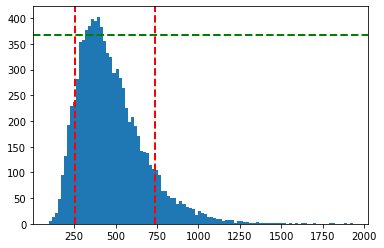

In [16]:
plt.hist(ending_price_points,bins=100)
plt.axvline(top_ten,color='r',linestyle='dashed',linewidth=2)
plt.axvline(bottom_ten,color='r',linestyle='dashed',linewidth=2)
plt.axhline(apple['Adj Close'][-1],color='g', linestyle='dashed',linewidth=2)
plt.show()